# PytzMLS2018:  Lab 3: Introduction to deep learning

<center>**Anthony Faustine (sambaiga@gmail.com)**</center>



## Import all necessary libries and modules we will use

In [3]:
import sys
sys.path.append('../src')
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
import torch.nn.functional as F
from ploting import *

%matplotlib inline

## Part 1. Feed-forward Neural Network

**Learning goal**: How to implement a feed-forward neural network by using PyTorch. In this lab we will train a feed-forward neural network by using PyTorch. We will do the following steps in order:

**Task**: Build MLP classifier to recognize handwritten digits using the MNIST dataset. MNIST contains 70,000 images: 60,000 for training and 10,000 for testing. The images are grayscale, 28x28 pixels, and centered to reduce preprocessing and get started quicker. 

** Procedure**

1. Load the training and test datasets using DataLoader
2. Define a Feedforwad Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1.1 Load dataset

We will use DataLoader and TensorDataset (from torch.utils.data) for convinience in data handling. You can create your custom dataset class by inheriting Dataset with some required member functions.

In [4]:
train_dataset = datasets.MNIST(root='../data/mnist', 
                            train=True, # this is training data
                            transform=transforms.ToTensor(),# Converts a PIL.Image or numpy.ndarray to
                                                           # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
                            download=True)

test_dataset = datasets.MNIST(root='../data/mnist', 
                           train=False, 
                           transform=transforms.ToTensor())

### 1.1.1 Make iteratable data loader

In [5]:
batch_size = 32


train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

### 1.1.2  Visualize train dataset


Let's inspect a few examples. The MNIST dataset contains only grayscale images. For more advanced datasets, we'll have the three color channels (RGB).

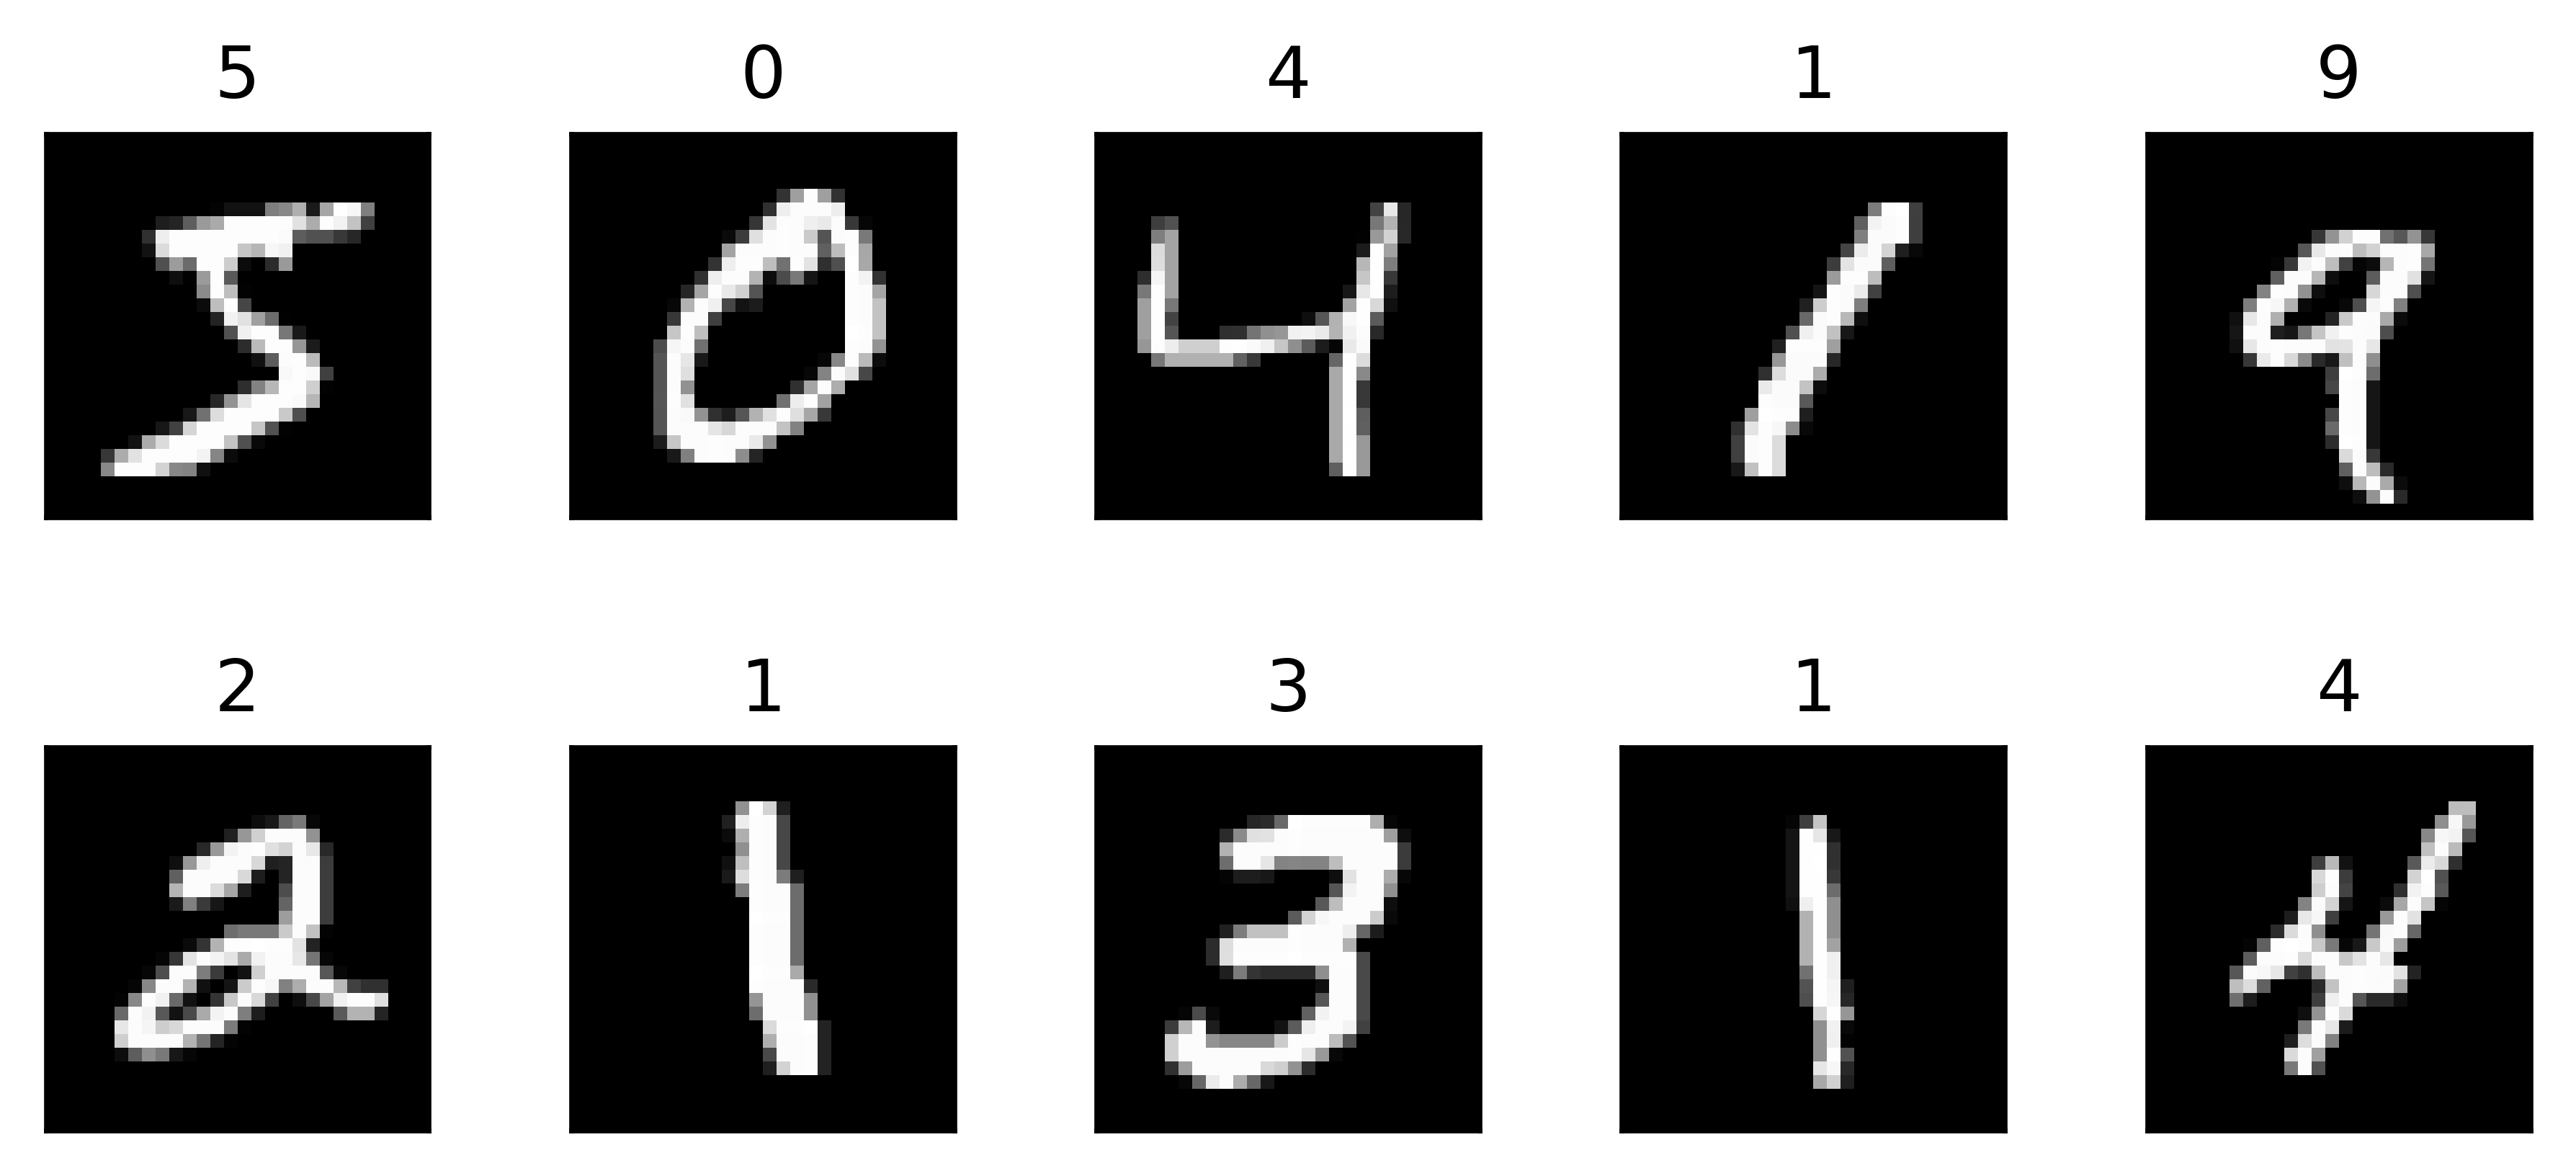

In [8]:
beatify(fig_width=6)
fig, axs = plt.subplots(2,5, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.25, wspace=.1)
axs = axs.ravel()

for i in range(10):
    axs[i].imshow(train_dataset.train_data[i].numpy(), cmap='gray', interpolation='none')
    axs[i].set_title('%i' % train_dataset.train_labels[i], fontsize=12)
    plt.tight_layout()
    axs[i].set_xticks([])
    axs[i].set_yticks([])
  
  

### 1.2. Define  MLP model

In this step we define MLP model. For simplicity, we will use 3-layer MLP in which each layer is a fully-connected layer and apply RELU activation for each layer with exception to the output layer. 

**Questions**
1. Why can't we apply RelU activation function to the output layer?
2. Which output activation function is appropriate for this type of problem?

In [9]:
def MLP(input_dim, hidden_dim, output_dim):
    
    
    model = nn.Sequential(
    nn.Linear(input_dim,hidden_dim), 
    nn.ReLU(),
    nn.Linear(hidden_dim,hidden_dim), 
    torch.nn.ReLU(),
    nn.Linear(hidden_dim,output_dim)
    )
    
    return model


In [10]:
input_dim = 784 #28X28
hidden_dim = 16
output_dim = 10


model = MLP(input_dim, hidden_dim, output_dim)
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=10, bias=True)
)


### 1.3. Define a Loss function and Optimizer¶

Since this is multi-class classification we will use **Cross Entropy loss**. PyTorch provide **Cross Entropy loss**  loss function which combines a softmax layer and the **Cross Entropy loss** together and it is more numerically stable than using them separately. Thus it is why we didnt  apply softmax activation after the output layer while defining MLP model. See the last model definition above.

We will use SGD with momentum as our optimizer. When we create an optimizer in PyTorch, we need to pass parameters that we want to optimize (train) as input arguments. We can retrieve all trainable parameters of the model by calling **model.parameters()**.

**Questions**
1. Write an expression of a softmax function.
2. What are the advantage of using SGD with momentum in training neural network?

In [13]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer =  torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

### 1.4. Train the network
Now, we need to train the model. For each full coverage of train dataset, we just need to do a forward pass computation with a mini-batch of dataset and a backward pass to compute gradients followed by a step of optimization. We need to do this for a reasonable number of iterations.

In [15]:
def train(model, optimizer, num_epochs):
    
    
    total_loss = []
    print("Start training")
    
    for epoch in range(num_epochs):
        
        training_loss = []
        
        model.train()
        
        for i, (images, labels) in enumerate(train_loader):
            
            images = Variable(images.view(-1, 28*28))
            labels = Variable(labels)
        
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()
        
            # Forward pass to get output/logits
            outputs = model(images)
        
            # Calculate Loss: softmax --> cross entropy loss
            loss = criterion(outputs, labels)
            training_loss.append(loss.data[0])
        
            # Getting gradients w.r.t. parameters
            loss.backward()
        
            # Updating parameters
            optimizer.step()
        
            # print statistics
            # print statistics
           
            if i %4000 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.4f}'.format(
                epoch+1, i * len(images), len(train_loader.dataset),
                100. * i / len(train_loader), np.mean(training_loss)))
             
              
        total_loss.append(np.mean(training_loss))     
        
       
    return total_loss    
          

In [16]:
#train models
total_loss = train(model, optimizer, 10)

Start training
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.2771
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.6414
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.2339
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.2453
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.4649
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.3325
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.3980
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.2117
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.0895
Train Epoch: 10 [0/60000 (0%)]	Loss: 0.2804


### 1.4.1 Visualize training loss

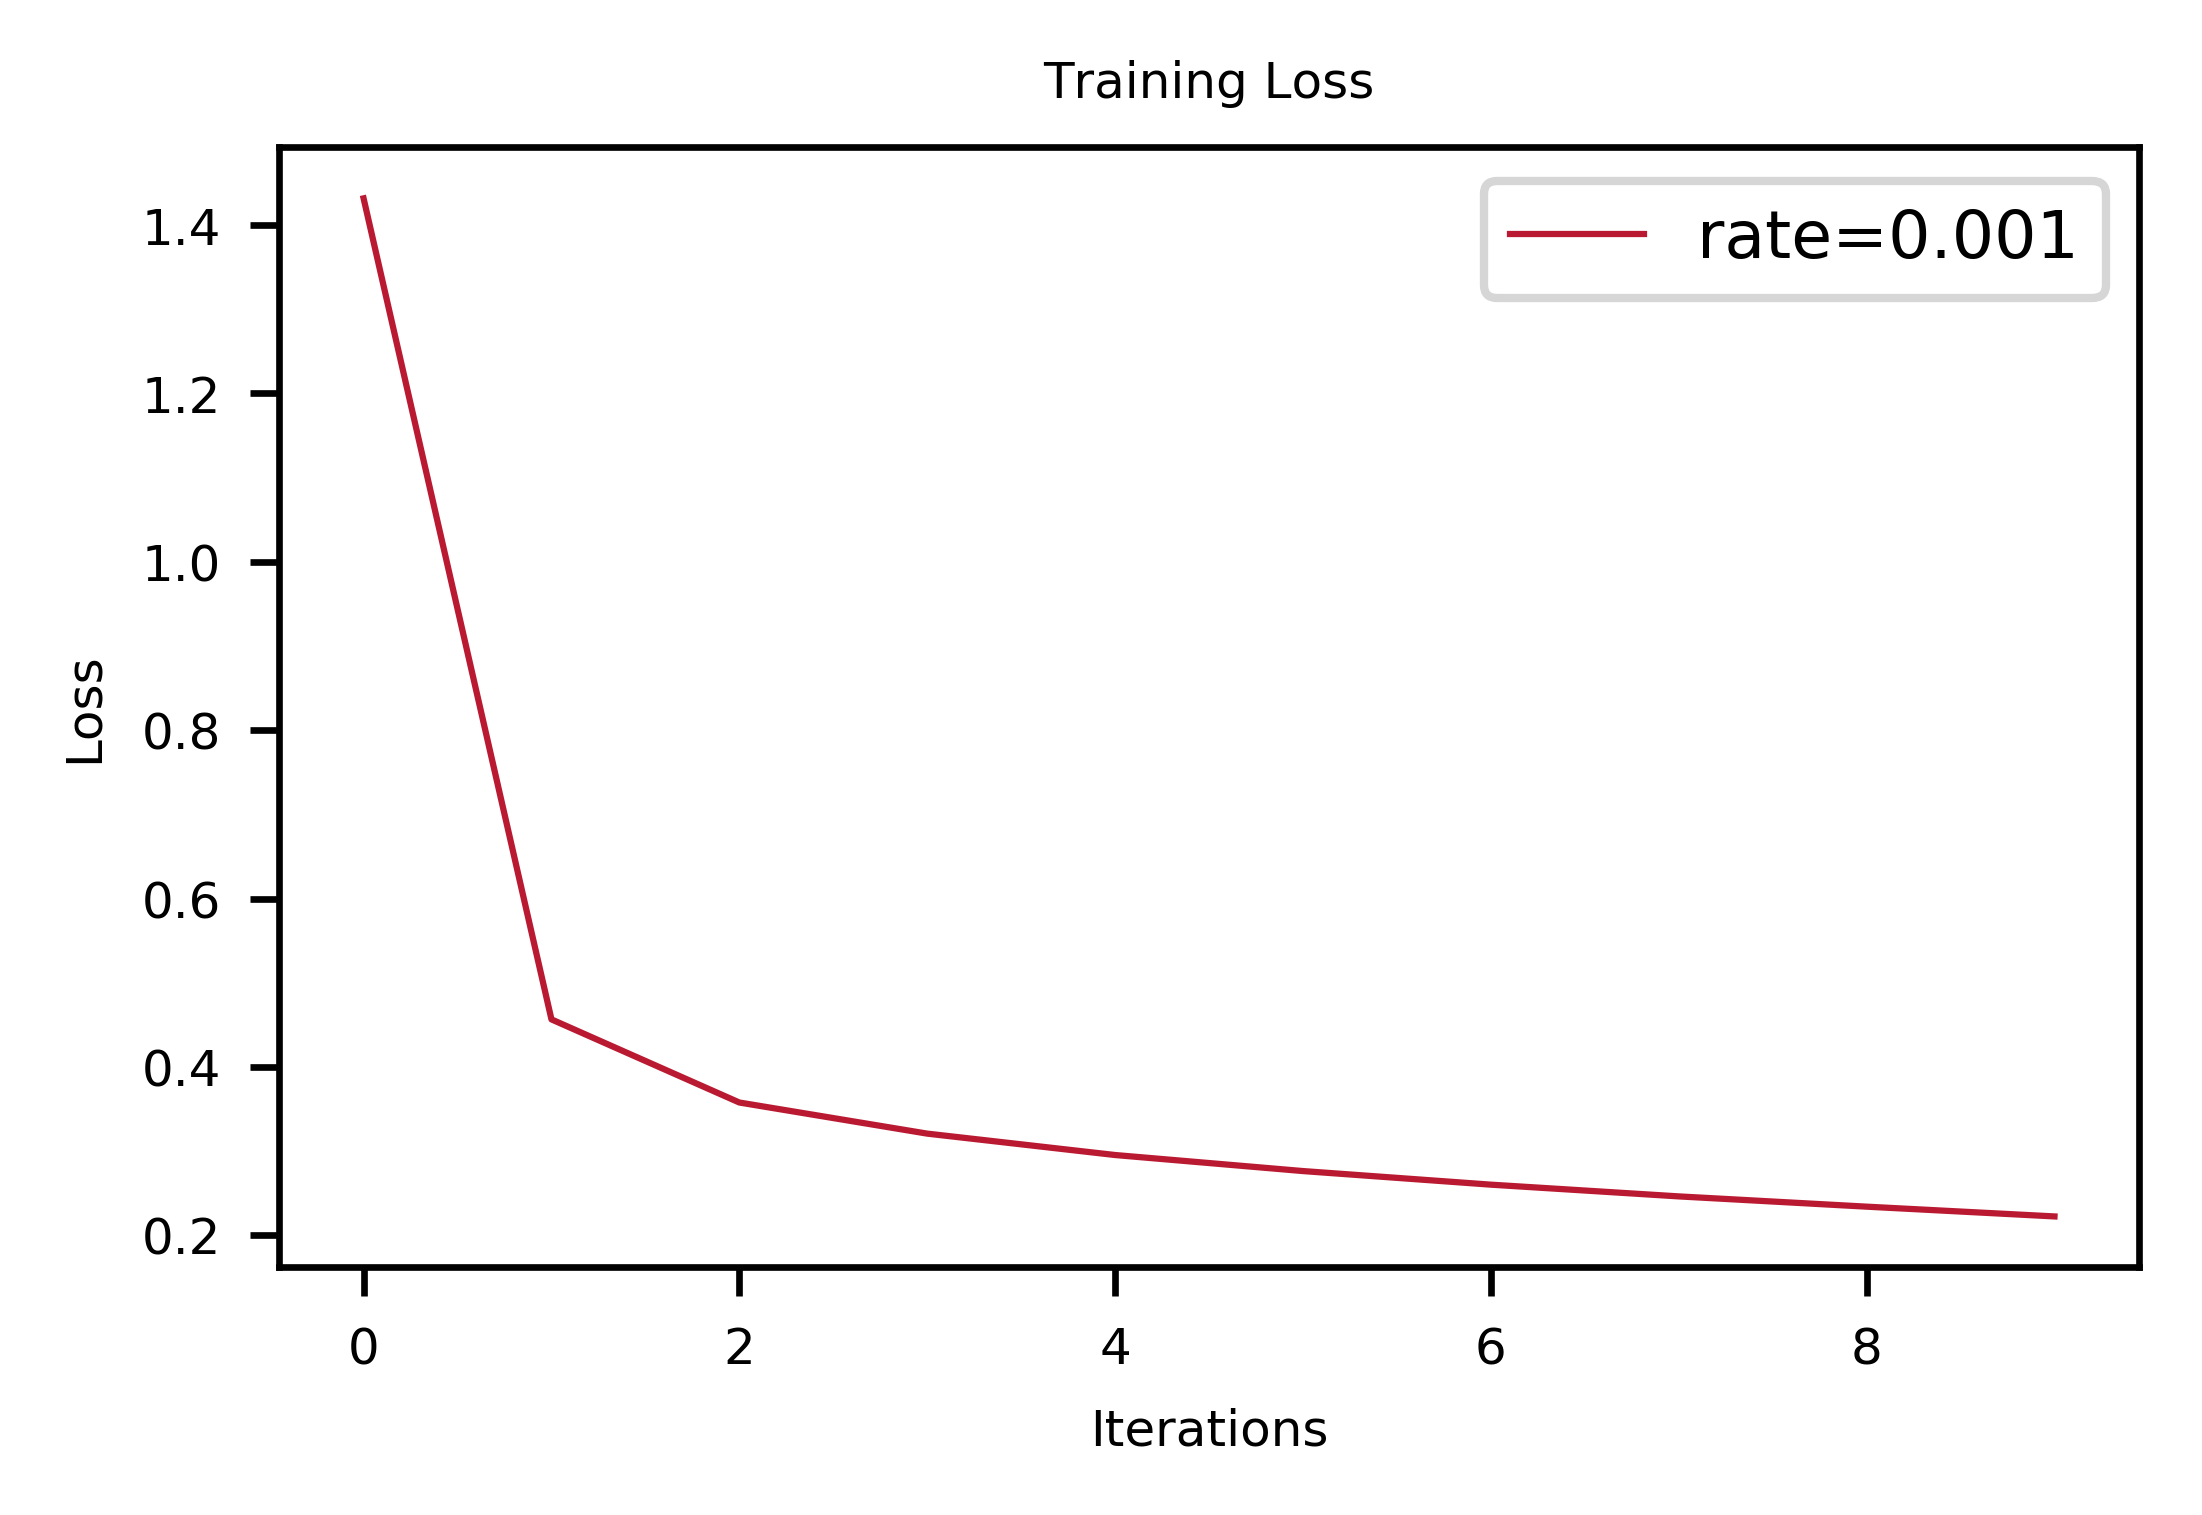

In [20]:
beatify(fig_width=4)
plt.plot(total_loss, label="rate={}".format(learning_rate))
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend();

### 1.5 Test the network on the test data

In [21]:
def test(model):
    
    model.eval()
    
    correct = 0
    predictions=[]
    ground_t=[]
    
    for i, (images, labels) in enumerate(test_loader):
        images = Variable(images.view(-1, 28*28))
        labels = Variable(labels)

        outputs = model(images)
        
        # Get predictions from the maximum value
        _, pred = torch.max(outputs.data, 1)
        predictions  += pred.numpy().tolist()
        ground_t+= labels.data.numpy().tolist()
        #correct += pred.eq(labels.data.view_as(pred)).cpu().sum()
        correct += torch.sum(pred == labels.data)
    
    print('')
    predictions = np.array(predictions)
    ground_t    = np.array(ground_t)   
    accuracy = 100. * correct / len(test_loader.dataset)
        
    print("Accuracy: {}%".format(accuracy))
    
    return ground_t, predictions
    
    

In [22]:
ground_t, predictions = test(model)


Accuracy: 93.68%


### 1.5.1 VIsualize Results

In [23]:
correct_indices = np.nonzero(predictions == ground_t)[0]
incorrect_indices = np.nonzero(predictions != ground_t)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")


9368  classified correctly
632  classified incorrectly


### 1.5.1.1 Visualize correct prediction

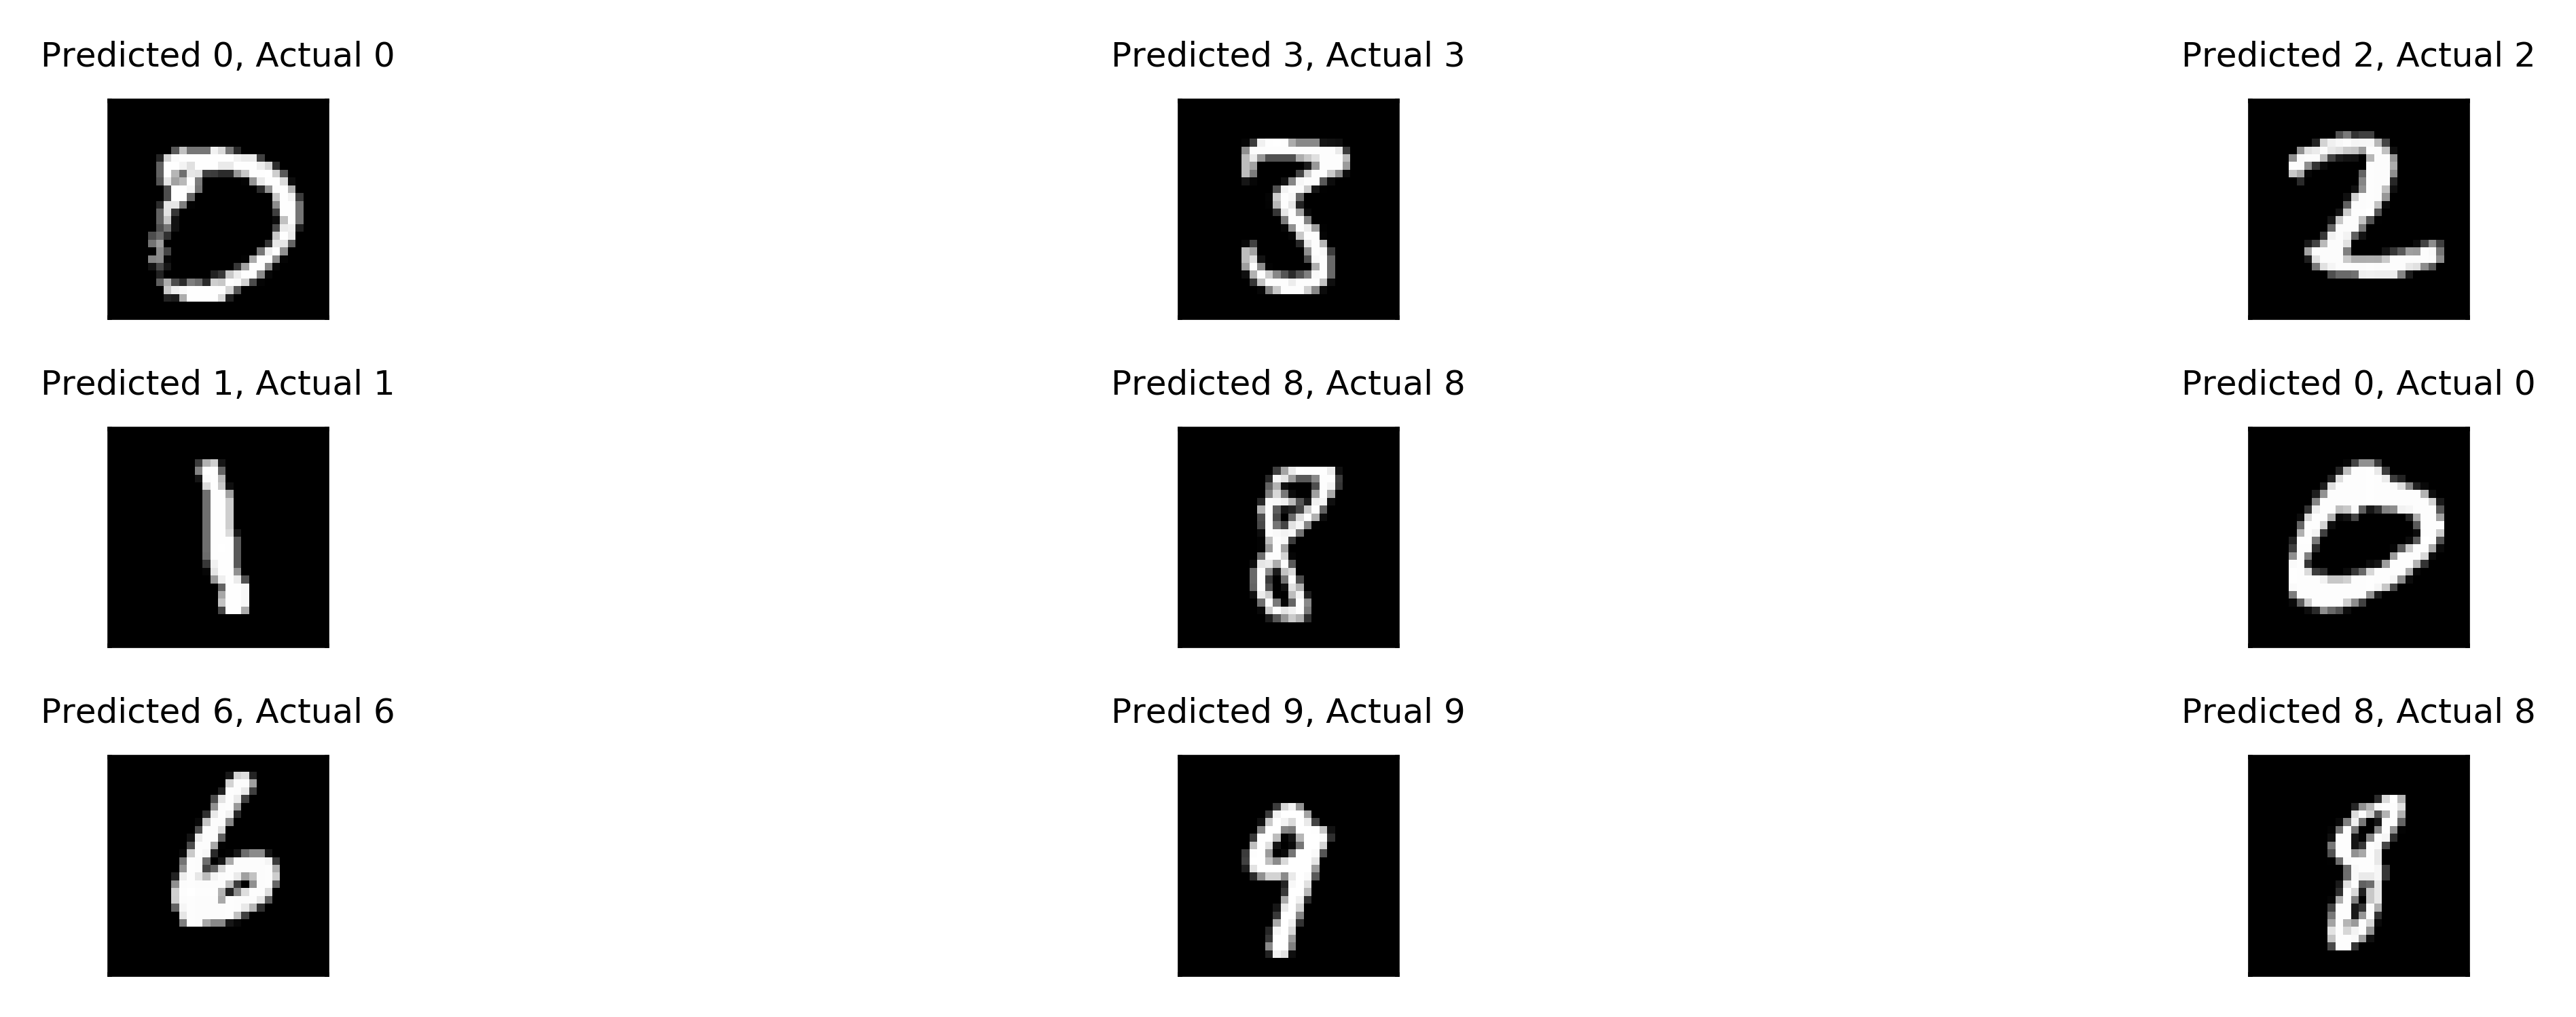

In [25]:
beatify(fig_width=8)
indices = np.random.permutation(correct_indices)
figure_evaluation = plt.figure()

# plot 9 correct predictions
for i, correct in enumerate(indices[:9]):
    plt.subplot(6,3,i+1)
    plt.imshow(test_dataset.test_data[correct].numpy(),  cmap='gray', interpolation='none')
    plt.title("Predicted {}, Actual {}".format(predictions[correct], ground_t[correct]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

#### 1.5.1.2 Visualize incorrect prediction

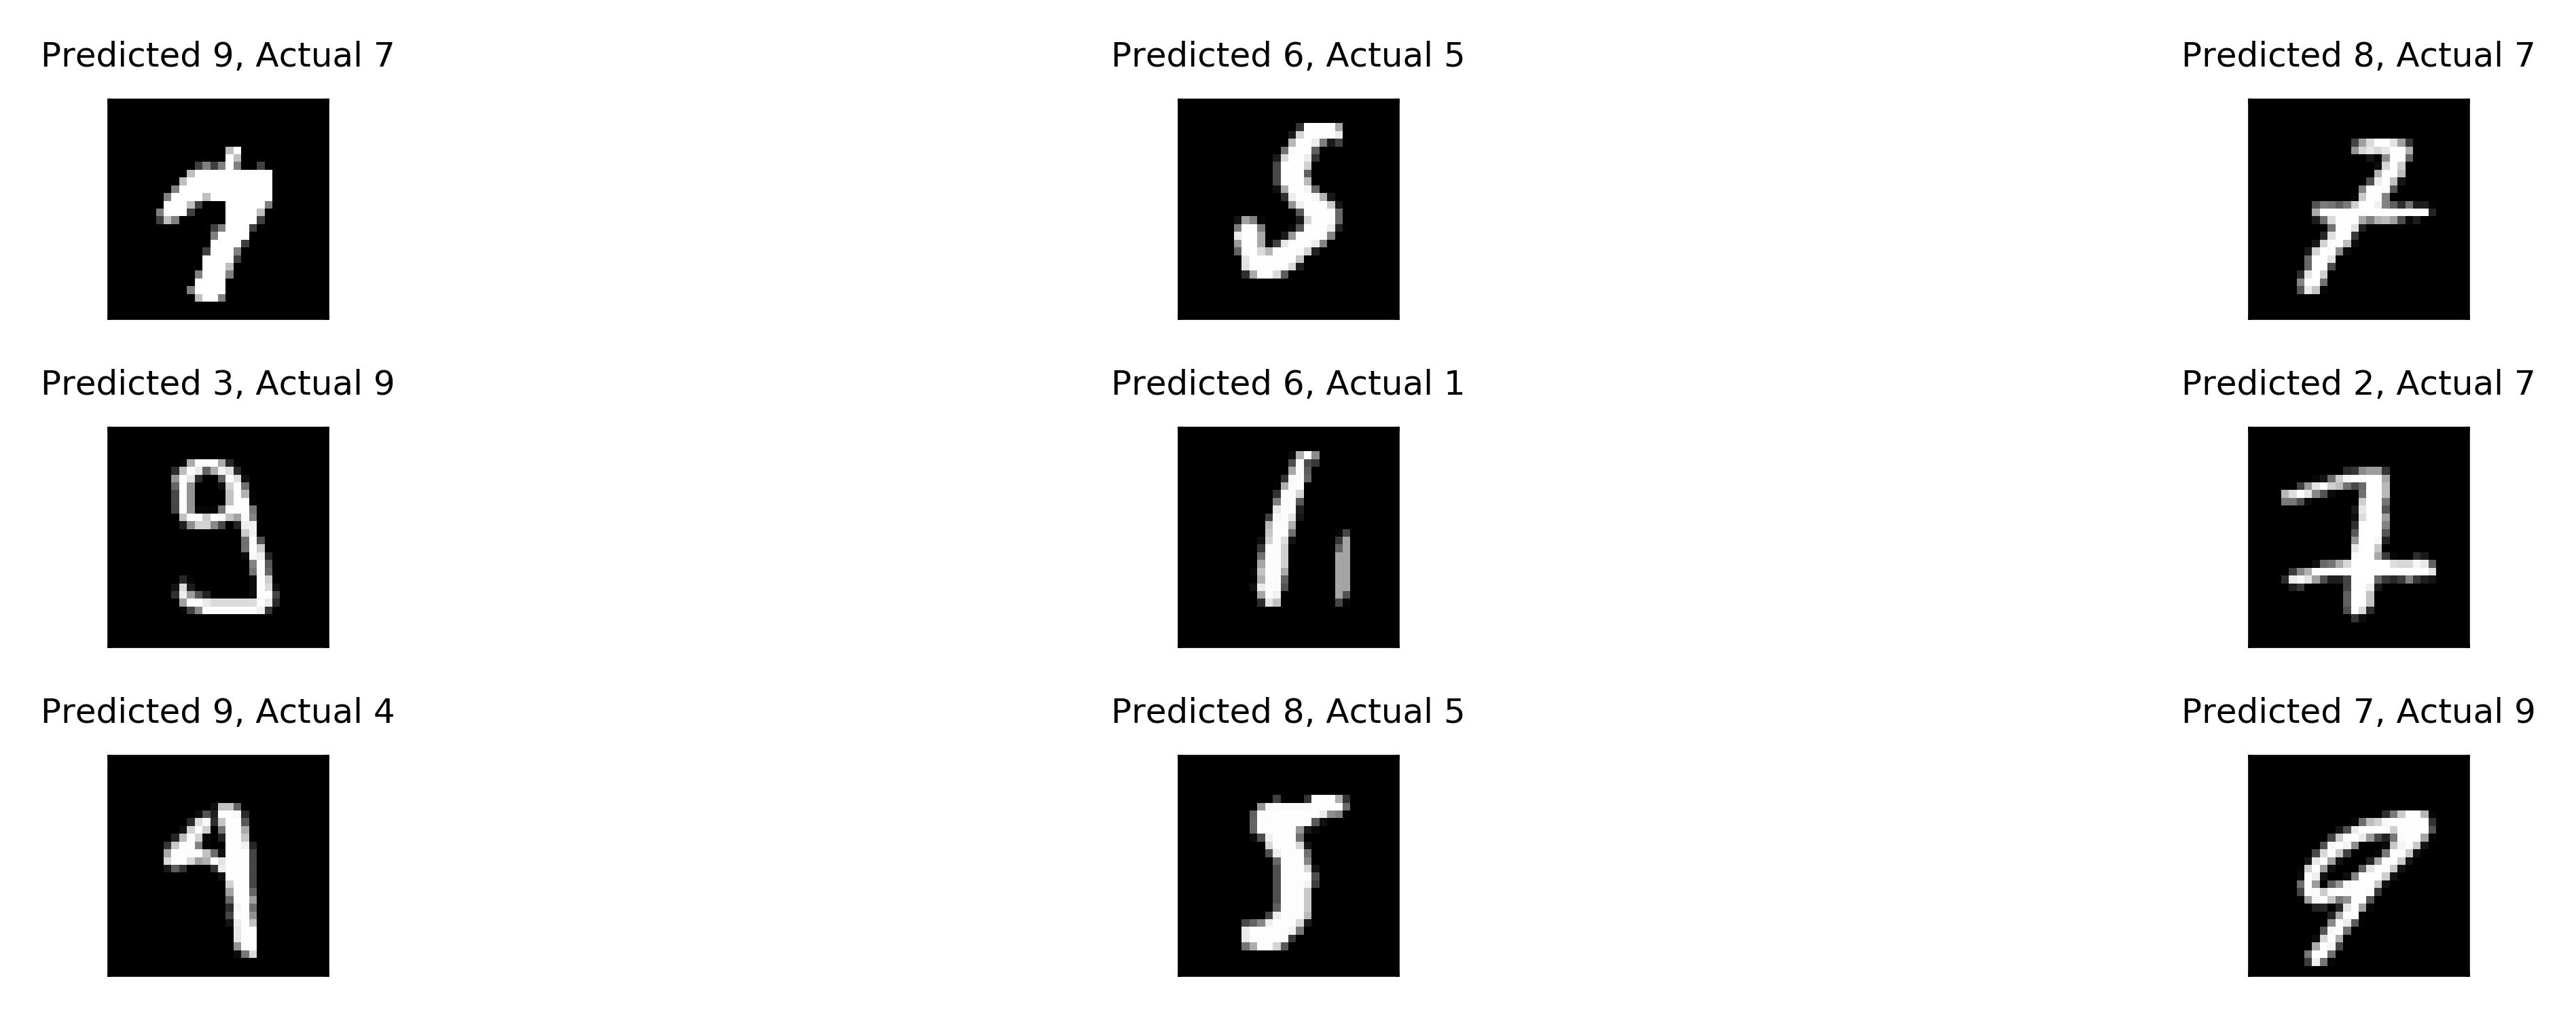

In [27]:
beatify(fig_width=8)
indices = np.random.permutation(incorrect_indices)
figure_evaluation = plt.figure()

# plot 9 correct predictions
for i, correct in enumerate(indices[:9]):
    plt.subplot(6,3,i+1)
    plt.imshow(test_dataset.test_data[correct].numpy(), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Actual {}".format(predictions[correct], ground_t[correct]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### 1.5.2 Experiment with other classification metrics implemented in sklearn

**Confusion matrix**

A confusion matrix is a technique for summarizing the performance of a classification algorithm. It is a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class. This is the key to the confusion matrix.

Classification accuracy alone can be misleading if you have an unequal number of observations in each class or if you have more than two classes in your dataset.

Calculating a confusion matrix can give you a better idea of what your classification model is getting right and what types of errors it is making.

For detail on confusion matrix refer [here](https://machinelearningmastery.com/confusion-matrix-machine-learning/) and [here](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)

We use [sklearn library](http://scikit-learn.org/stable/) to calculate confusion matrix and [searborn library](https://seaborn.pydata.org/) to plot the confusion matrix.

In [28]:
from sklearn.metrics import  confusion_matrix
cm=confusion_matrix(ground_t, predictions)
cm

array([[ 955,    0,    1,    2,    0,   10,    8,    2,    1,    1],
       [   0, 1104,    3,    3,    1,    1,    3,    4,   16,    0],
       [  10,    3,  971,    4,    5,    4,   10,   10,   15,    0],
       [   5,    0,   21,  910,    0,   27,    3,   17,   20,    7],
       [   1,    1,    6,    0,  921,    0,   13,    2,    6,   32],
       [   8,    1,    4,   22,    7,  798,   15,    3,   27,    7],
       [  11,    3,    2,    1,   11,   13,  917,    0,    0,    0],
       [   1,    7,   23,    6,    5,    1,    0,  958,    3,   24],
       [   5,    5,    4,   16,    9,   18,   11,    6,  895,    5],
       [  11,    9,    1,    5,   21,    4,    0,    9,   10,  939]])

Our class in digits from 0 to 10.

In [29]:
class_names = np.unique(ground_t)
class_names

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [30]:
import seaborn as sn

def confusion_matrix_plot(cm, class_names):
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    try:
        heatmap = sn.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
     

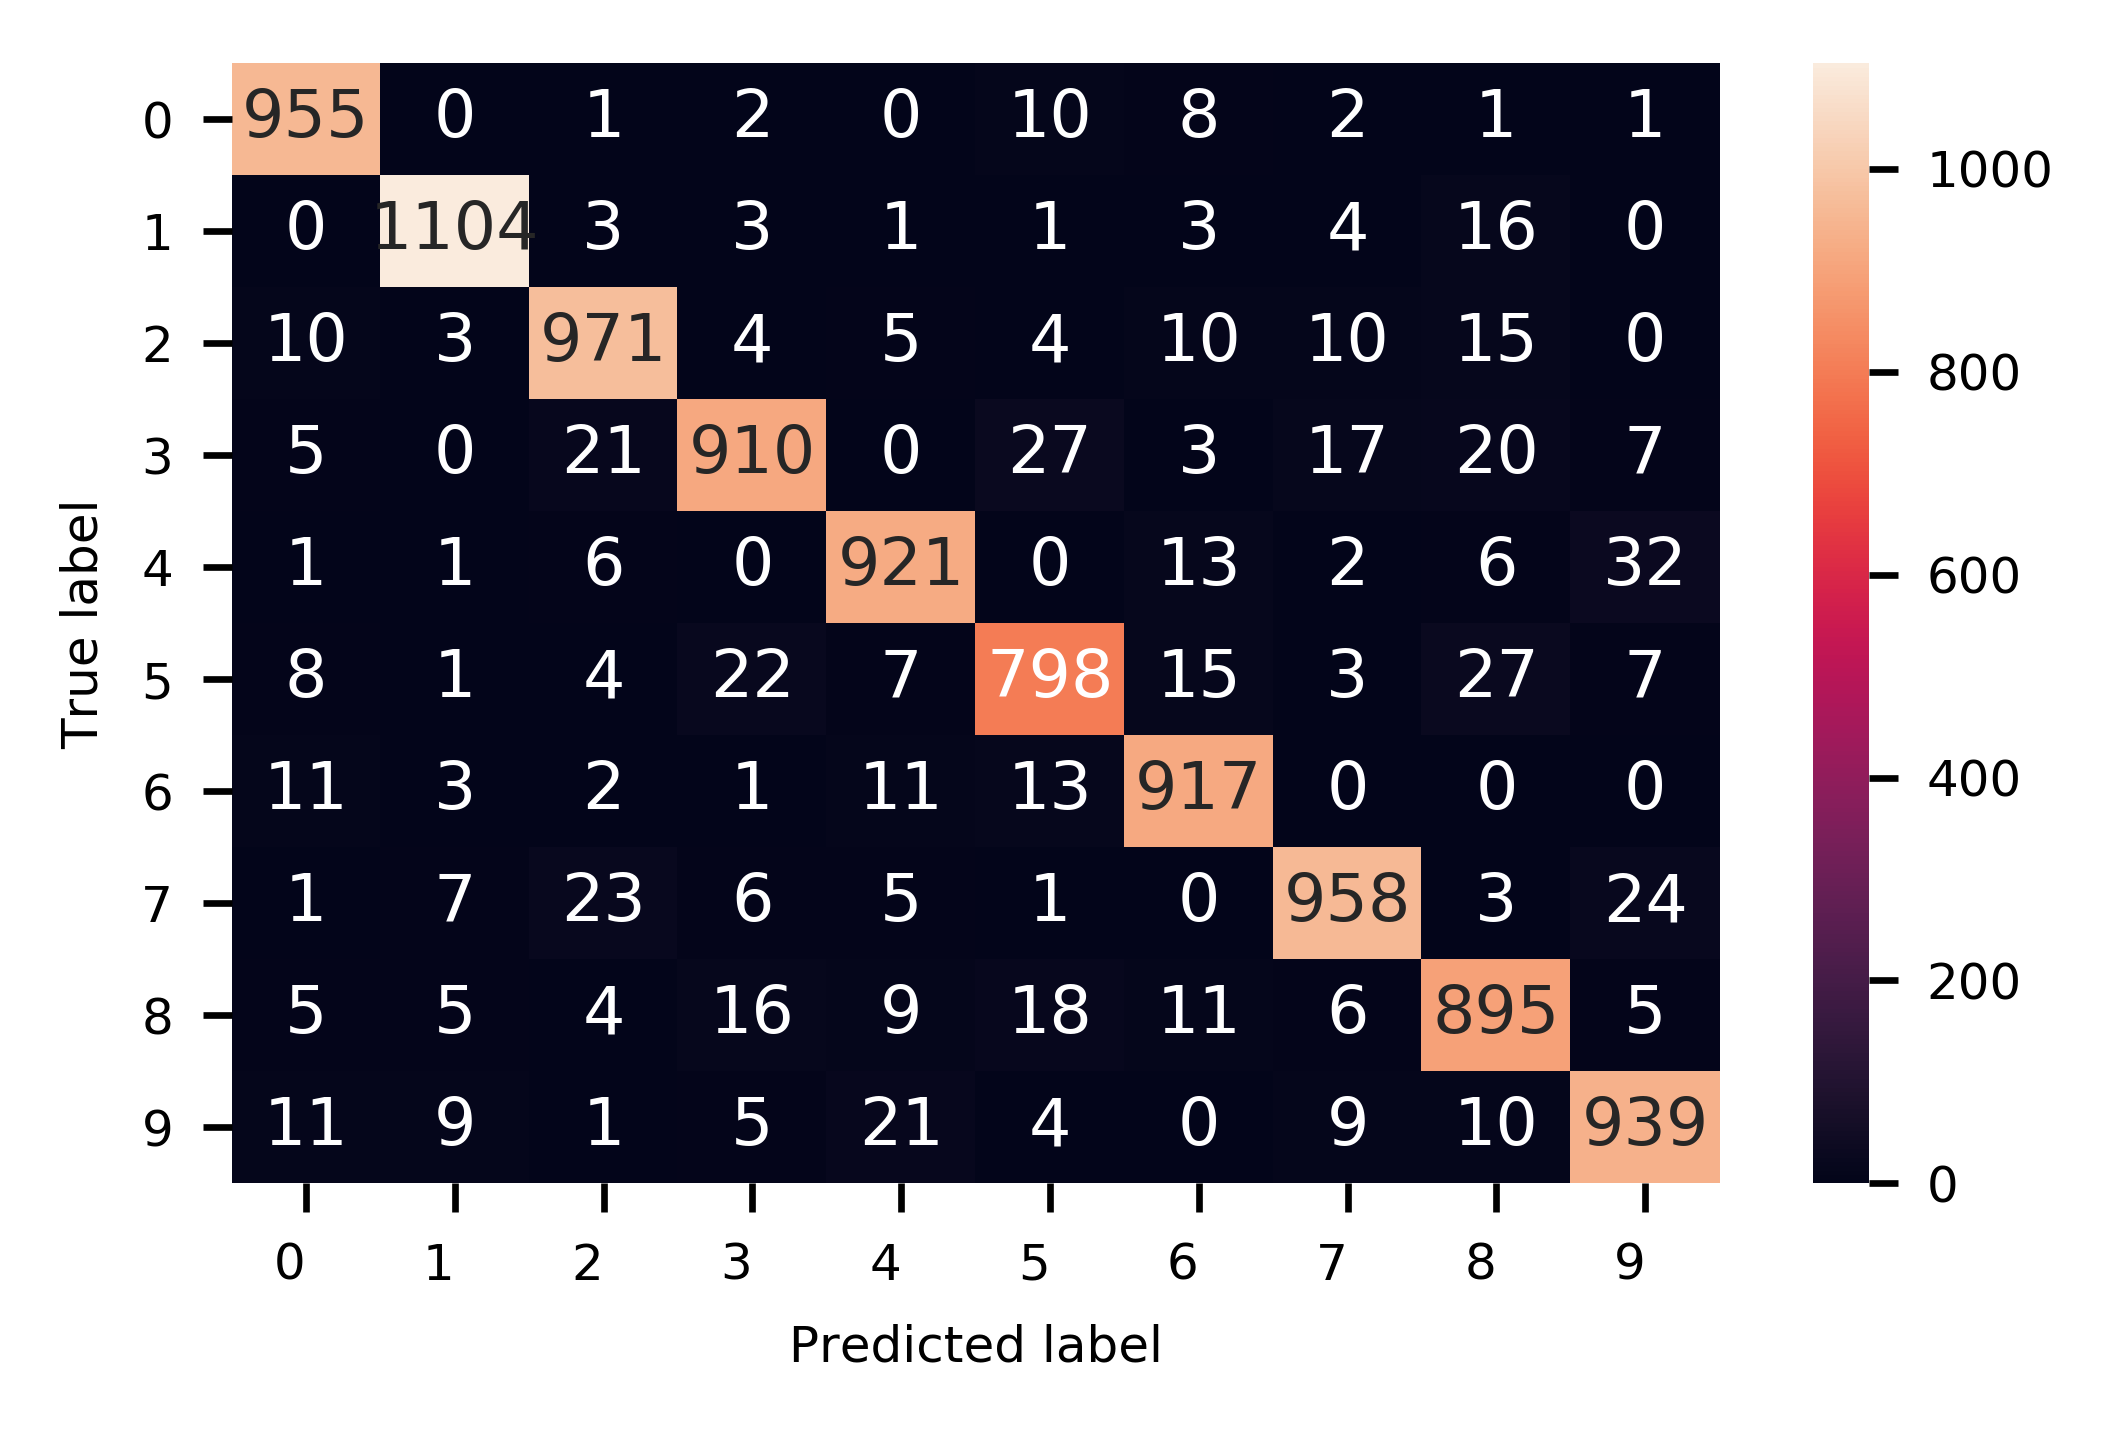

In [31]:
beatify(fig_width=4)
confusion_matrix_plot(cm, class_names)

### 1.5.3 [** Recall, Precision and F-measure**](https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/)

**Recall (Sensitivity)**: is the ratio of correctly predicted positive observations to the all observations in actual class. 
$$Recall = \frac{TP}{TP + FN}$$

**Precision**  is the ratio of correctly predicted positive observations to the total predicted positive observations. 

$$Precision = \frac{TP}{TP + FP}$$

**F1 score**: is the weighted average of Precision and Recall, it takes both false positives and false negatives into account.

$$F1 Score = \frac{2\cdot Recall \cdot Precision} {Recall + Precision}$$

In [32]:
from sklearn.metrics import f1_score, precision_score,recall_score

In [33]:
recal = recall_score(ground_t, predictions, average='weighted')
prec  = precision_score(ground_t, predictions, average='weighted')
f1    = f1_score(ground_t, predictions, average='weighted')
print("Recall: {0:.4f}, Precision: {1:.4f}, F-score: {2:.4f}".format(recal,prec, f1))

Recall: 0.9368, Precision: 0.9368, F-score: 0.9367


## Part 2. Weight Initilization 

Before  training neural network we have to initialize its parameters. By default pytorch itinilize this parameters for you. However you can use different techniques such as gausian random initilization, kaiming and xavier initialization. In this part we will experiment with the following initilization zero, kaiming and xavier initilization and comprae their results with defaulty initilization. We will modify the previous model by adding weight initilization.

In pytorch most initilization functions are implemented in [**torch.nn.init**](http://pytorch.org/docs/0.3.1/nn.html#torch-nn-init). As discussed in tutorial we need to define initilization function that we apply to model parameters.

### 2.1. Zero weight initilization

In this case we initilize the weight to zero by first defining a function that willinitilize  weight of the nn.Linear module as follows.

In [34]:
def zero_weights_init(m): 
    if isinstance(m, nn.Linear):
        m.weight.data.fill_(0.0)
        m.bias.data.fill_(0.0)

Define a model and apply zero weight initilization

In [35]:
model_weight_zero =  MLP(input_dim, hidden_dim, output_dim)

Apply the weight init function to the defined model

In [36]:
model_weight_zero.apply(zero_weights_init)
print(model_weight_zero)

Sequential(
  (0): Linear(in_features=784, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=10, bias=True)
)


 Let us check to see if the initial weight is zero

In [37]:
for  param in model_weight_zero.parameters():
    print(param.data[0])


 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0


 We can now build and test our model

In [38]:
optimizer =  torch.optim.SGD(model_weight_zero.parameters(), lr=learning_rate, momentum=0.9)
total_loss_zero_weight = train(model_weight_zero, optimizer, 10)

Start training
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.3026
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.3090
Train Epoch: 3 [0/60000 (0%)]	Loss: 2.3132
Train Epoch: 4 [0/60000 (0%)]	Loss: 2.2898
Train Epoch: 5 [0/60000 (0%)]	Loss: 2.2905
Train Epoch: 6 [0/60000 (0%)]	Loss: 2.2938
Train Epoch: 7 [0/60000 (0%)]	Loss: 2.3102
Train Epoch: 8 [0/60000 (0%)]	Loss: 2.3057
Train Epoch: 9 [0/60000 (0%)]	Loss: 2.3140
Train Epoch: 10 [0/60000 (0%)]	Loss: 2.3117


Let us compare the training loss when zero initilization is applied

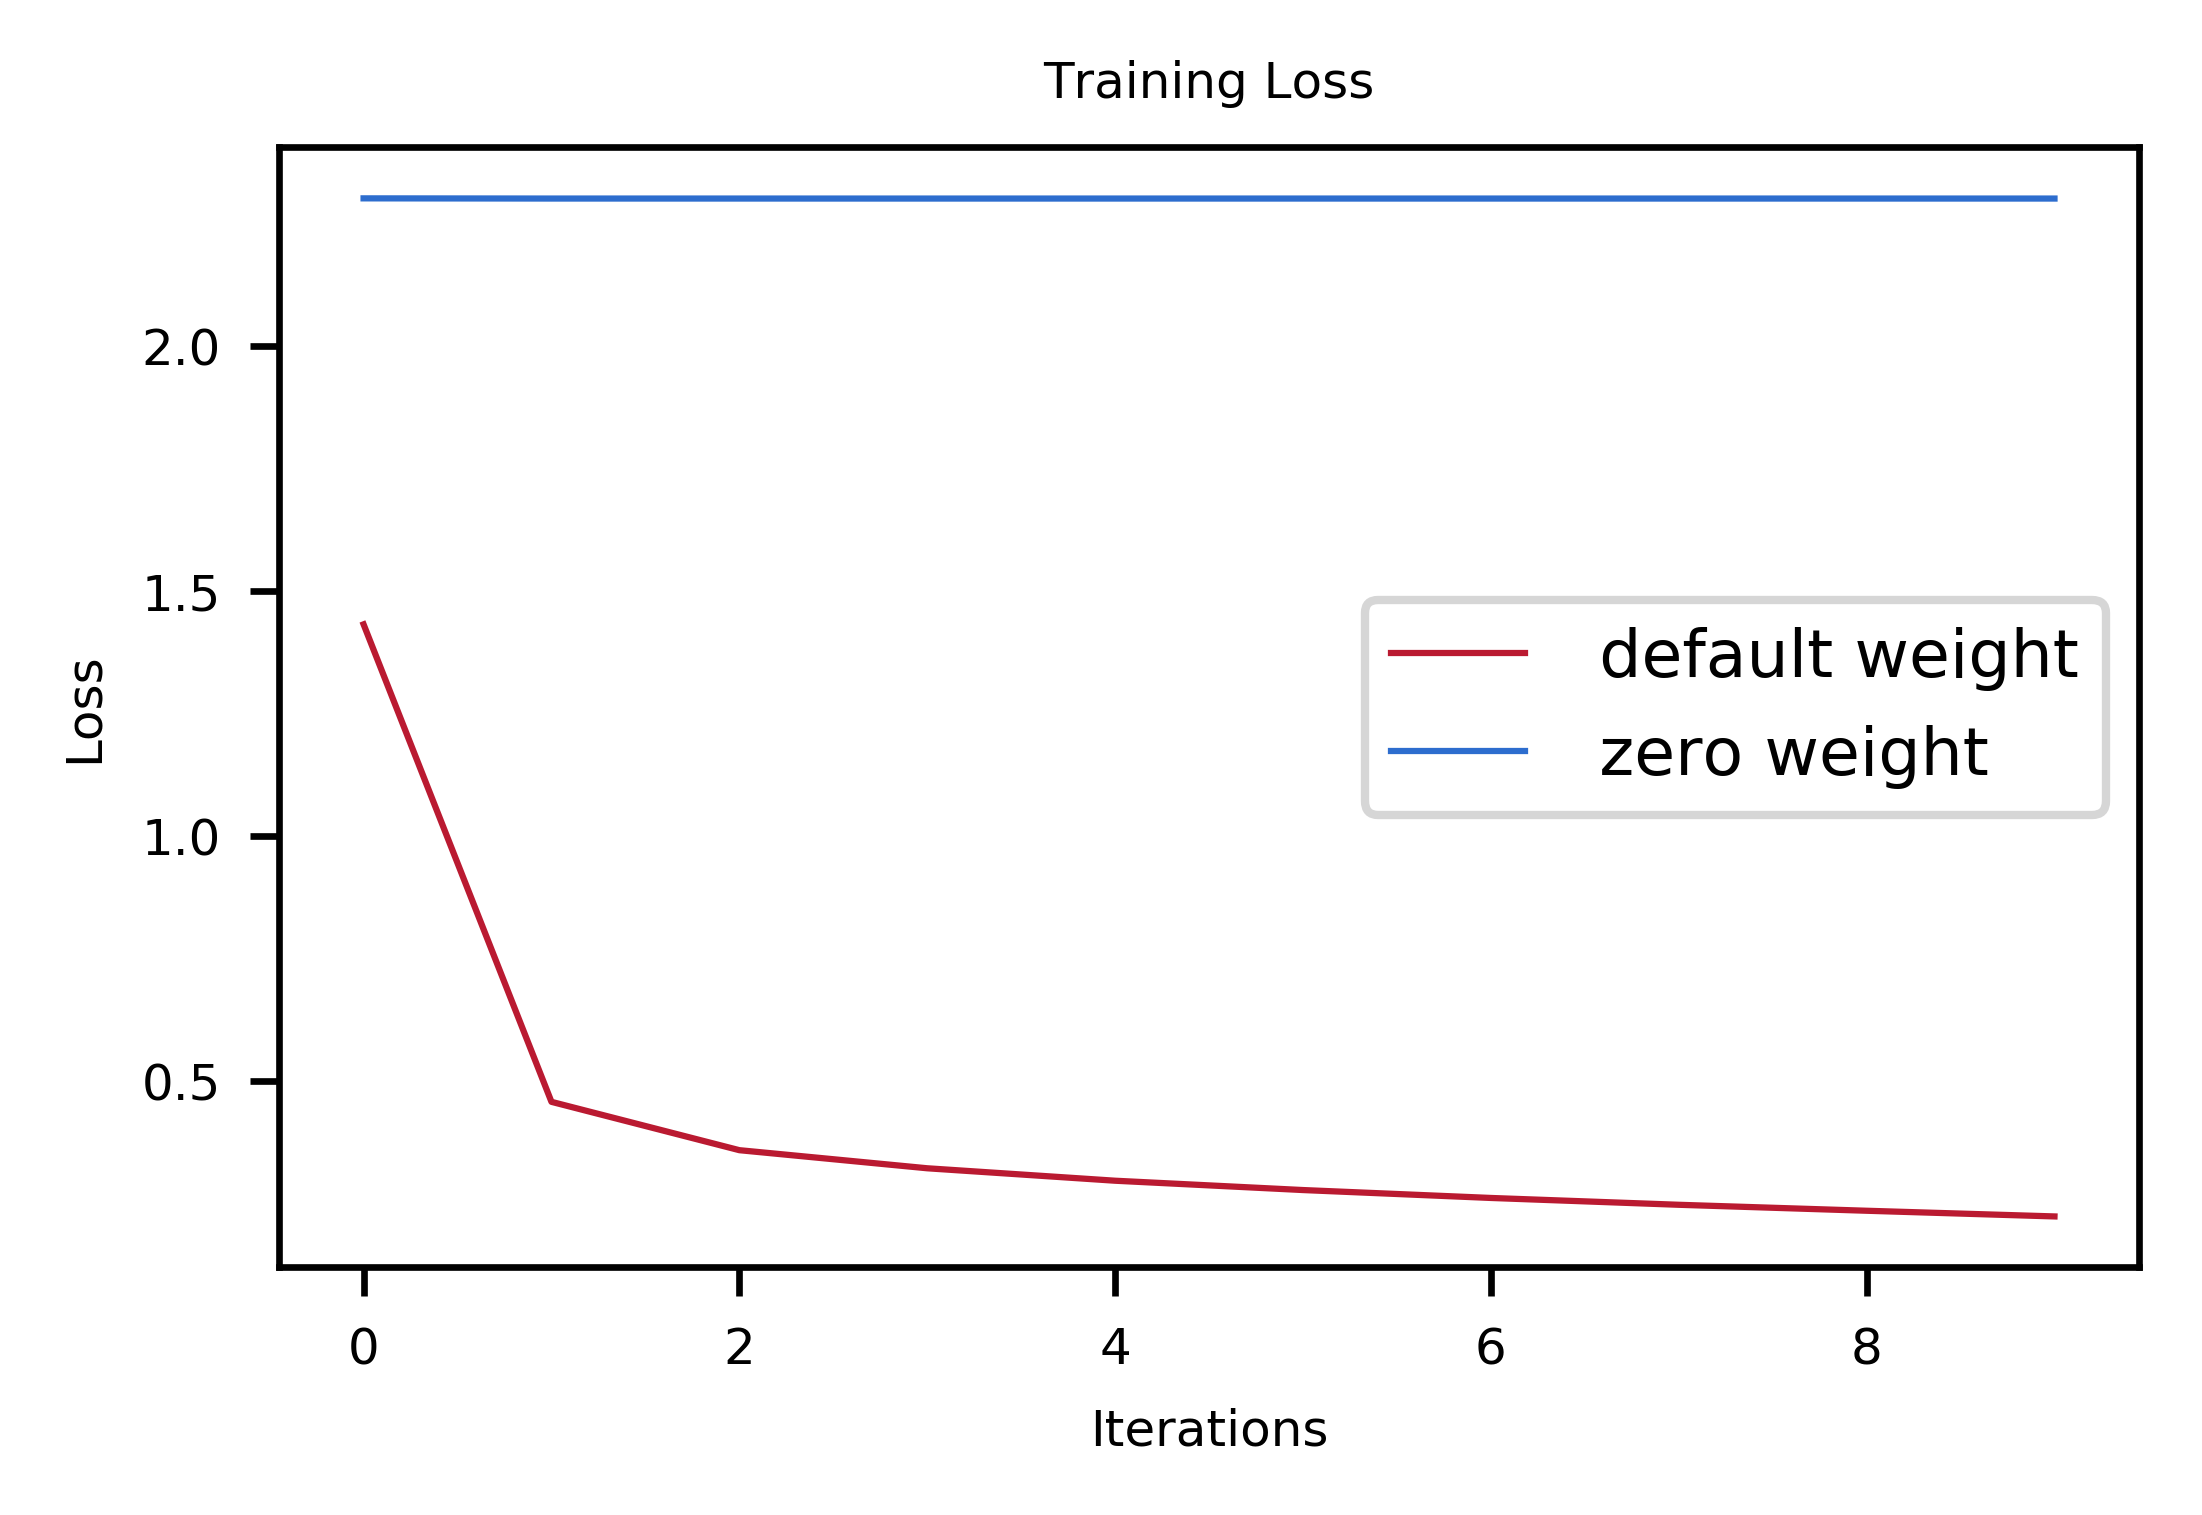

In [39]:
plt.plot(total_loss, label=" default weight")
plt.plot(total_loss_zero_weight, label=" zero weight")
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

#### Questions
1. What can you conclude on the above results?

### 2.2 Xavier weight initilization

Implemented in [**torch.nn.init.xavier_uniform**](http://pytorch.org/docs/0.3.1/nn.html#torch-nn-init). We will repeat the same procedure as in 2.1 but with xavier weight initilizer.

In [40]:
def xavier_weights_init(m): 
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal(m.weight)
        m.bias.data.fill_(0.0)
        

        
model_xavier =  MLP(input_dim, hidden_dim, output_dim)

model_xavier.apply(xavier_weights_init)
print(model_xavier)        
        

Sequential(
  (0): Linear(in_features=784, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=10, bias=True)
)


In [42]:
for  param in model_xavier.parameters():
    print(param.data[0])


-0.0506
-0.0215
-0.0165
-0.0135
-0.0356
-0.0719
 0.0084
-0.0258
 0.0188
 0.0672
 0.0249
-0.0186
 0.0182
 0.0998
 0.0208
 0.0470
-0.0201
-0.0605
 0.0186
 0.0253
-0.0399
 0.0098
-0.0659
 0.0156
 0.0017
 0.0454
 0.0737
 0.0321
-0.0276
 0.0288
-0.0517
 0.0819
 0.0036
-0.0266
-0.0138
-0.0007
-0.0290
-0.0539
 0.0347
-0.0265
 0.0357
-0.0176
 0.0629
 0.0963
 0.0394
 0.0449
 0.1302
-0.0569
 0.0754
 0.0180
 0.0364
 0.0162
-0.0133
 0.0053
-0.0640
 0.0365
 0.0037
-0.0460
-0.0604
-0.0169
-0.0360
 0.0282
-0.0528
-0.0200
 0.0727
-0.0836
-0.0762
-0.0248
-0.0517
-0.0656
-0.0217
-0.0559
 0.0641
-0.0450
-0.0965
-0.0724
 0.0152
-0.0013
-0.0152
-0.0064
-0.0728
 0.0254
-0.0657
-0.0201
-0.0336
 0.1296
 0.0434
 0.0286
 0.0348
 0.0428
 0.0232
-0.0185
 0.0504
-0.0467
-0.0366
 0.0544
 0.0025
 0.0630
 0.0039
 0.0085
 0.0434
-0.0570
 0.0110
-0.0144
 0.0145
-0.0523
 0.0679
-0.0196
-0.0723
-0.0459
-0.0048
 0.0359
 0.0739
-0.0557
-0.0954
-0.0148
-0.0572
 0.0122
 0.0377
-0.1599
 0.0347
-0.0279
 0.0553
-0.0021
-0.0205

In [43]:
optimizer =  torch.optim.SGD(model_xavier.parameters(), lr=learning_rate, momentum=0.9)
total_loss_xavier = train(model_xavier, optimizer, 10)

Start training
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.4007
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.4852
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.4180
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.1706
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.3350
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.5247
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.1351
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.2791
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.2537
Train Epoch: 10 [0/60000 (0%)]	Loss: 0.1869


### 2.3 Kaiming weight initilization

Implemented in [**torch.nn.init.kaiming_normal()**](http://pytorch.org/docs/0.3.1/nn.html#torch-nn-init). We will repeat the same procedure as in 2.2 but with kaiming weight initilizer.

In [44]:
def kaiming_weights_init(m): 
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal(m.weight)
        m.bias.data.fill_(0)

In [45]:
model_kaiming =  MLP(input_dim, hidden_dim, output_dim)

model_kaiming.apply(kaiming_weights_init)
print(model_kaiming)

Sequential(
  (0): Linear(in_features=784, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=10, bias=True)
)


In [46]:
for param in model_kaiming.parameters():
    print(param.data[0])


-0.0458
-0.0459
 0.0507
-0.0337
 0.0688
-0.0477
 0.0423
 0.0761
 0.0598
-0.0491
-0.0033
 0.0726
 0.1050
-0.0198
 0.0626
 0.0053
 0.0426
-0.0109
-0.0595
 0.0662
-0.1010
 0.0221
-0.0762
 0.0434
 0.0425
 0.0513
-0.0226
-0.0470
-0.0076
-0.0263
-0.0137
 0.0067
 0.0159
 0.0174
 0.0084
 0.0229
-0.0155
-0.0635
 0.0361
-0.0275
-0.0224
-0.0299
-0.0447
-0.0240
-0.0272
 0.0682
-0.0796
 0.0015
 0.1100
 0.0775
 0.0187
-0.0237
-0.0173
 0.0597
 0.0265
-0.0397
-0.0665
-0.0243
 0.1130
-0.0247
 0.0215
-0.0043
 0.0128
 0.0043
-0.0152
 0.0768
-0.0159
 0.0608
-0.0150
 0.0345
 0.0942
-0.0122
-0.0278
 0.0147
-0.0058
-0.0096
 0.0379
-0.1046
 0.0698
-0.0548
-0.0117
 0.0390
-0.0729
-0.0141
-0.0858
 0.0667
-0.0277
 0.0250
 0.0242
 0.0194
-0.0617
 0.0240
 0.0036
-0.0979
 0.0535
 0.0569
-0.0328
 0.0107
-0.0104
 0.0264
-0.0044
 0.0909
 0.0621
-0.0434
 0.0285
-0.0363
 0.0233
-0.0185
 0.0404
 0.0262
 0.0217
-0.0801
-0.0526
-0.0995
 0.0450
-0.0441
 0.0785
-0.0467
 0.0400
-0.0918
 0.0174
 0.0240
 0.0942
-0.1491
-0.0035

In [47]:
optimizer =  torch.optim.SGD(model_kaiming.parameters(), lr=learning_rate, momentum=0.9)

In [48]:
total_loss_kaiming = train(model_kaiming, optimizer, 10)

Start training
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.4111
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.3953
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.2310
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.1791
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.4411
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.2647
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.2947
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.1649
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.1039
Train Epoch: 10 [0/60000 (0%)]	Loss: 0.1096


Now let compare the result of the three initilization; default, Xavier and kaiming.

**Task**: Plot the the three plot on the same graph

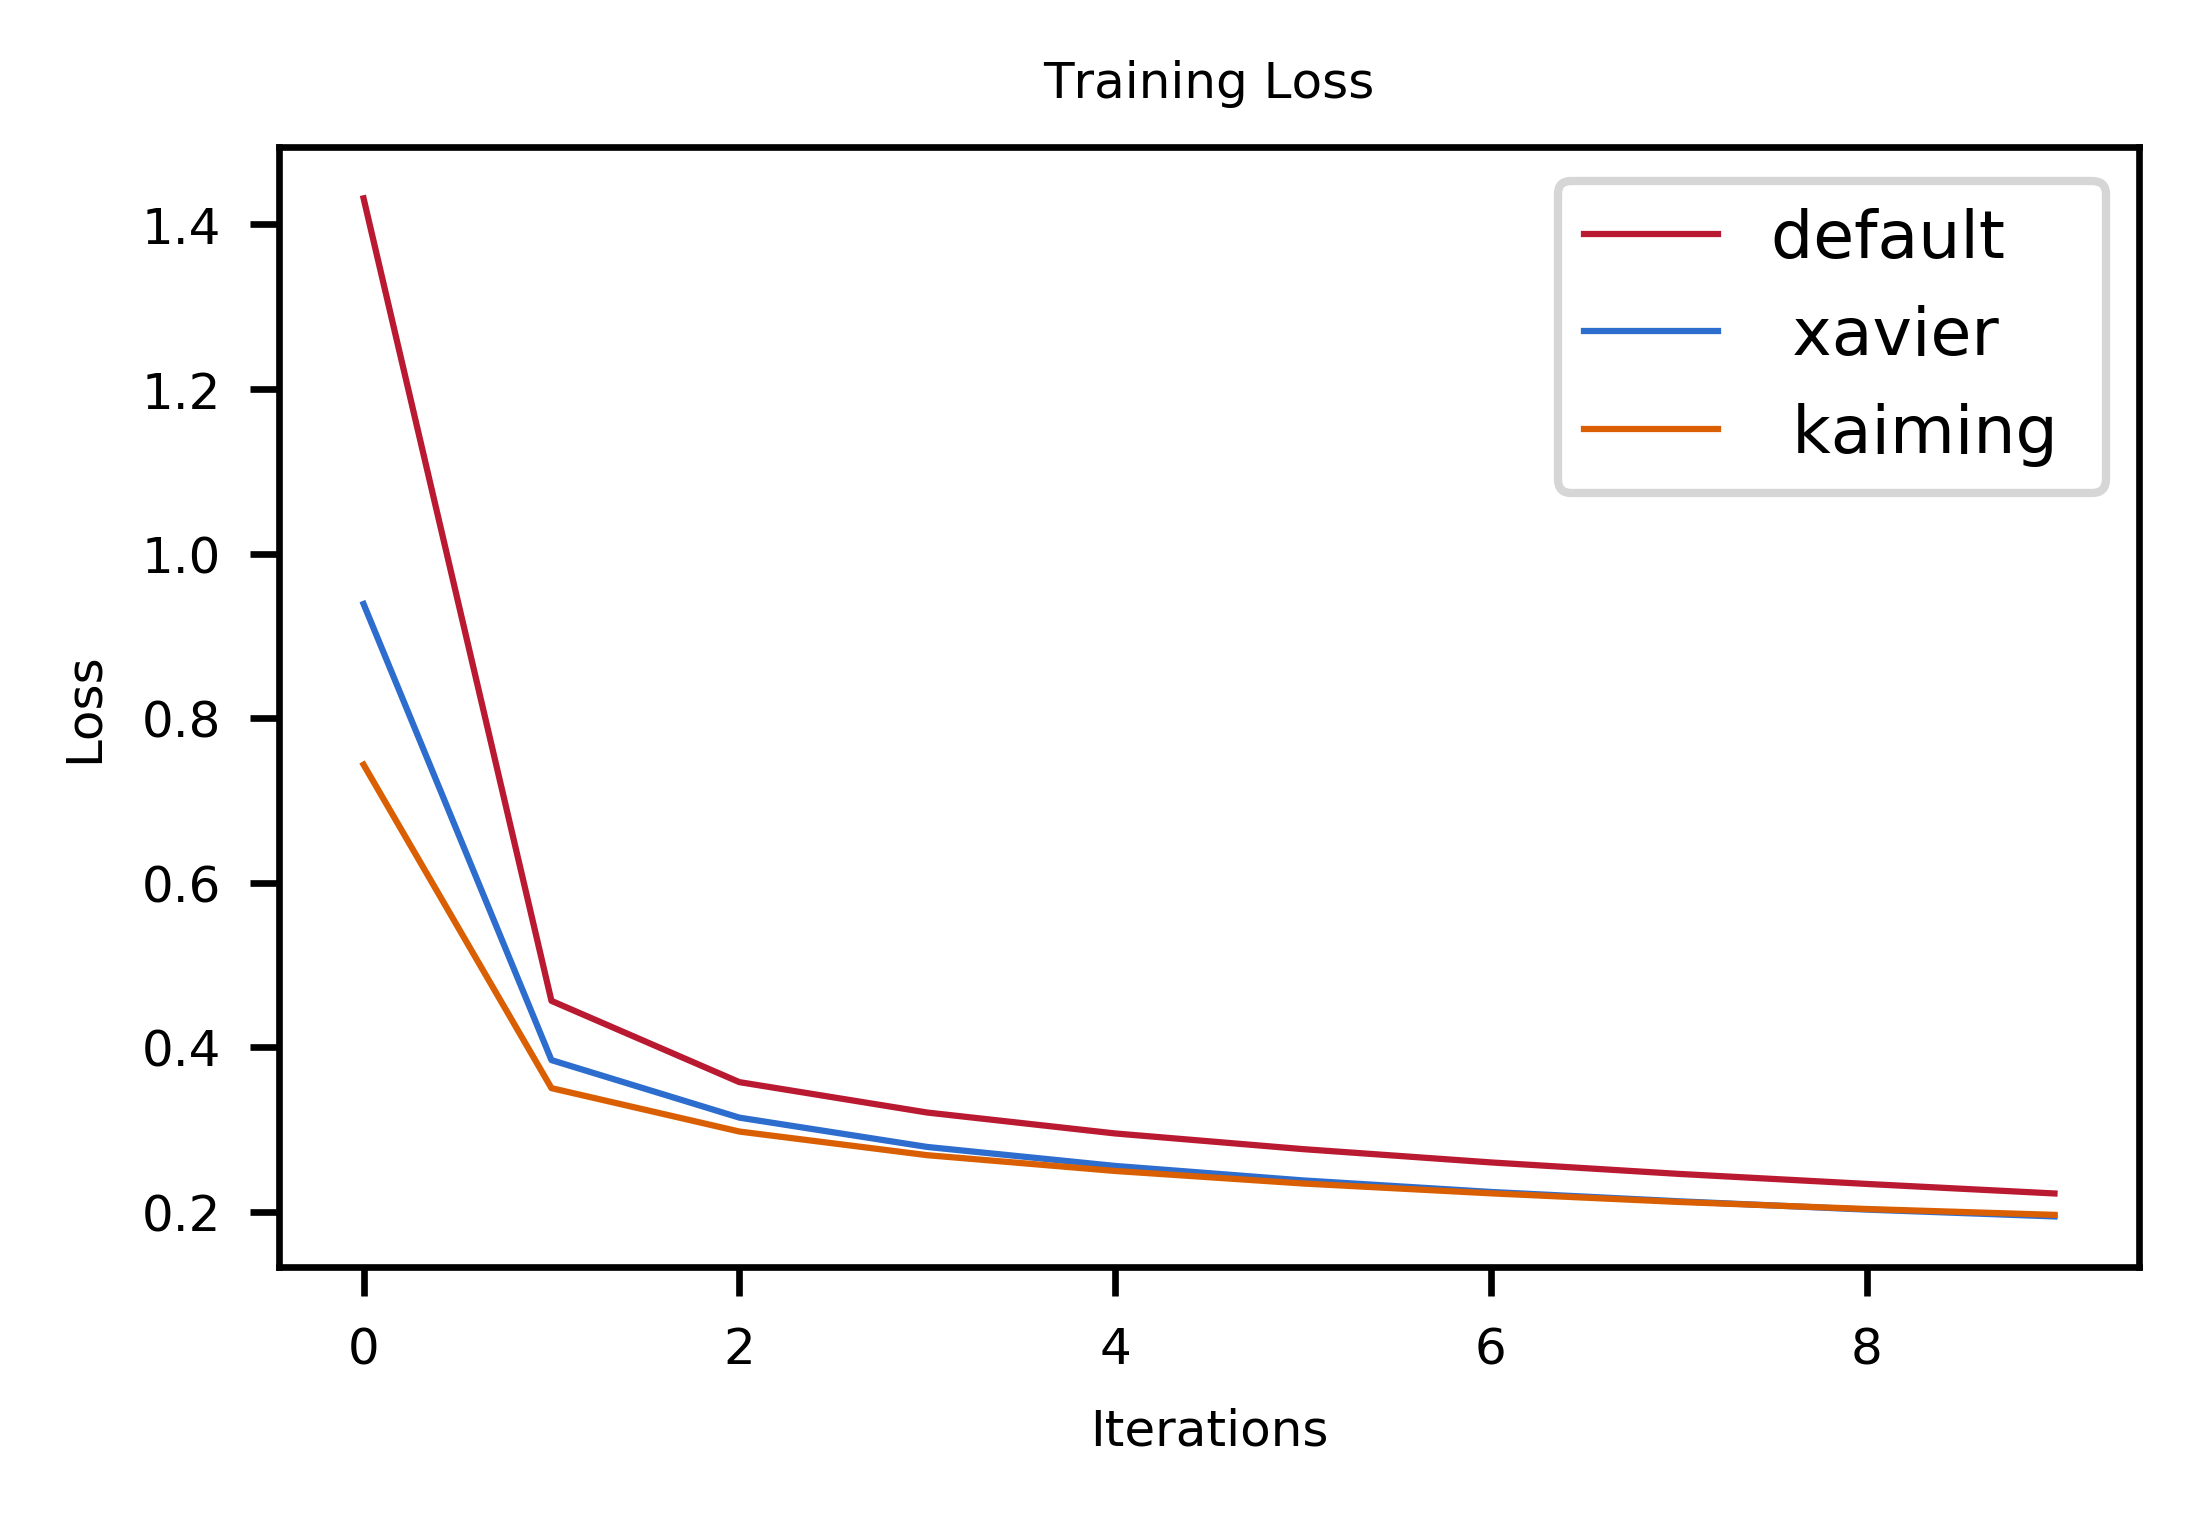

In [49]:
plt.plot(total_loss, label="default ")
plt.plot(total_loss_xavier, label=" xavier")
plt.plot(total_loss_kaiming, label=" kaiming ")
plt.title("Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

**Questions**:
1. Which initilization techniques is the best?

## Task: 
Use the best weight initilization to experiments with different learning rate ($0.0001,0.001, 0.01,1$) and different optimisation algorithm such as Adam (`torch.optim.Adam()`) 

### 2.3 Compare test results
Compare accuracy of the four model training with different initilization technoique

In [50]:
ground_zero, prediction_zero=test(model_weight_zero)


Accuracy: 11.35%


In [51]:
ground_xavier, prediction_xavier=test(model_xavier)


Accuracy: 94.08%


In [52]:
ground_kaming, prediction_kaiming=test(model_kaiming)


Accuracy: 94.25%


**Questions**

1. What can you conclude on weight initilization ?

## Part 3 Model complexity, overfitting & regularization

**Overfitting** occurs when improving the model's training loss (its performance on training data) comes at the expense of its generalisation ability (its performance on unseen test data). Generally it is a symptom of the model complexity increasing to fit the peculiarities (outliers) of the training data too accurately, causing it not to generalize well to new unseen (test) data. Overfitting is usually indicated when:

- training & validation loss starts decreasing at different rates,
- validation error starts increasing while training error still goes down,
- training error reaches 0.

**Underfitting** is the opposite: when a model cannot fit the training data well enough (usually a sign to train for longer or add more parameters to the model).

We can increase model complexity by adding more layers (i.e. more parameters). We can control or reduce the model complexity of an architecture using a family of techniques called **regularisers**. 

**Questions**

1. Which regularization techniques can be used to control model complexity?
2. What is the difference between $L1$ and $L2$ regularizers?



### 3.1 Early stopping

Neural networks are nonlinear models and can have very complicated optimization landscapes. Stochastic gradient based methods for optimizing these loss functions do not proceed monotonically (i.e. does not just keep going up). Sometimes the loss can go down for a while before it goes up to reach a better part of parameter space later. How do we know when to stop training?


**Early stopping** is one technique that helps with this. It is added to the training routine and means that we periodically evaluate the model's performance on the validation set. If the performance on the validation set starts becoming worse we know we have reached the point of overfitting (usually), so it usually makes sense to stop training and not waste any more computations.

There are different ways of implementing this early stopping in practise:

1. **Basic early stopping**:stop training as soon as the model starts doing worse on validation data.
2. **Early stopping with patience**: don't stop training immediately once validation accuracy degrades, but wait for P more epochs, and reset P if the model starts improving again within this timeframe.
3. **Eaarly stopping after T epoch**: training for T epochs, and simply selecting the best model based on validation score over the entire T epochs.


**Questions**

1. Why does early stopping rely on the model performance on validation set and not training set ?
2. What are the pros and cons of these different early stopping methods?


###  Basic early stopping

First let write a function to compare train and validation performance.

In [53]:
def fit_model(model, optimizer, num_epochs):
    
    total_train_loss = []
    total_val_loss = []
    total_train_acc = []
    total_val_acc = []
    
    print("Start training")
    for epoch in range(num_epochs):
        
        #Train
        running_loss = 0
        correct  = 0
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = Variable(images.view(-1, 28*28))
            labels = Variable(labels)
        
            optimizer.zero_grad()
            outputs = model(images)
        
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs.data, 1)
            
            
            running_loss += loss.data[0] * images.size(0)
            correct += torch.sum(preds == labels.data)
        
        
            loss.backward()
            optimizer.step()
        
        tra_loss=running_loss/len(train_loader.dataset)
        tra_cc=100. * correct / len(train_loader.dataset)
        
        #Validate
        model.eval()
        running_loss = 0
        correct  = 0
        for i, (images, labels) in enumerate(test_loader):
            images = Variable(images.view(-1, 28*28))
            labels = Variable(labels)
            outputs = model(images)
            
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs.data, 1)
            
            # statistics
            running_loss += loss.data[0] * images.size(0)
            correct += torch.sum(preds == labels.data)
            
        val_loss=running_loss/len(test_loader.dataset)
        val_acc=100. * correct / len(test_loader.dataset) 
        
        
        #save results
        total_train_loss.append(tra_loss)
        total_val_loss.append(val_loss)
        total_train_acc.append(tra_cc)
        total_val_acc.append(val_acc)
        
        if epoch%2==0:
            print("Epoch: {}, train_loss: {:.4f} , val_loss: {:.4f}, tra_acc: {:.2f}, val_acc: {:.2f}".format(epoch+1, tra_loss,val_loss, tra_cc, val_acc))
       
    plt.subplot(1,2,1)
    plt.plot(total_train_acc, label="Train")
    plt.plot(total_val_acc, label="Validation")
    plt.title("Accuracy vs Iteration")
    plt.xlabel("iterations")
    plt.ylabel("Accuracy %")
    plt.tight_layout()
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(total_train_loss, label="Train")
    plt.plot(total_val_loss, label="Validation")
    plt.title("Loss vs Iteration")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.legend()
          

In [54]:
model_early_stopping =  MLP(input_dim, hidden_dim, output_dim)

optimizer =  torch.optim.SGD(model_early_stopping .parameters(), lr=learning_rate, momentum=0.9)


Start training
Epoch: 1, train_loss: 1.3819 , val_loss: 0.5608, tra_acc: 56.55, val_acc: 83.41
Epoch: 3, train_loss: 0.3688 , val_loss: 0.3348, tra_acc: 89.41, val_acc: 90.47
Epoch: 5, train_loss: 0.2963 , val_loss: 0.2774, tra_acc: 91.47, val_acc: 92.17
Epoch: 7, train_loss: 0.2586 , val_loss: 0.2470, tra_acc: 92.53, val_acc: 92.93
Epoch: 9, train_loss: 0.2338 , val_loss: 0.2365, tra_acc: 93.23, val_acc: 93.10


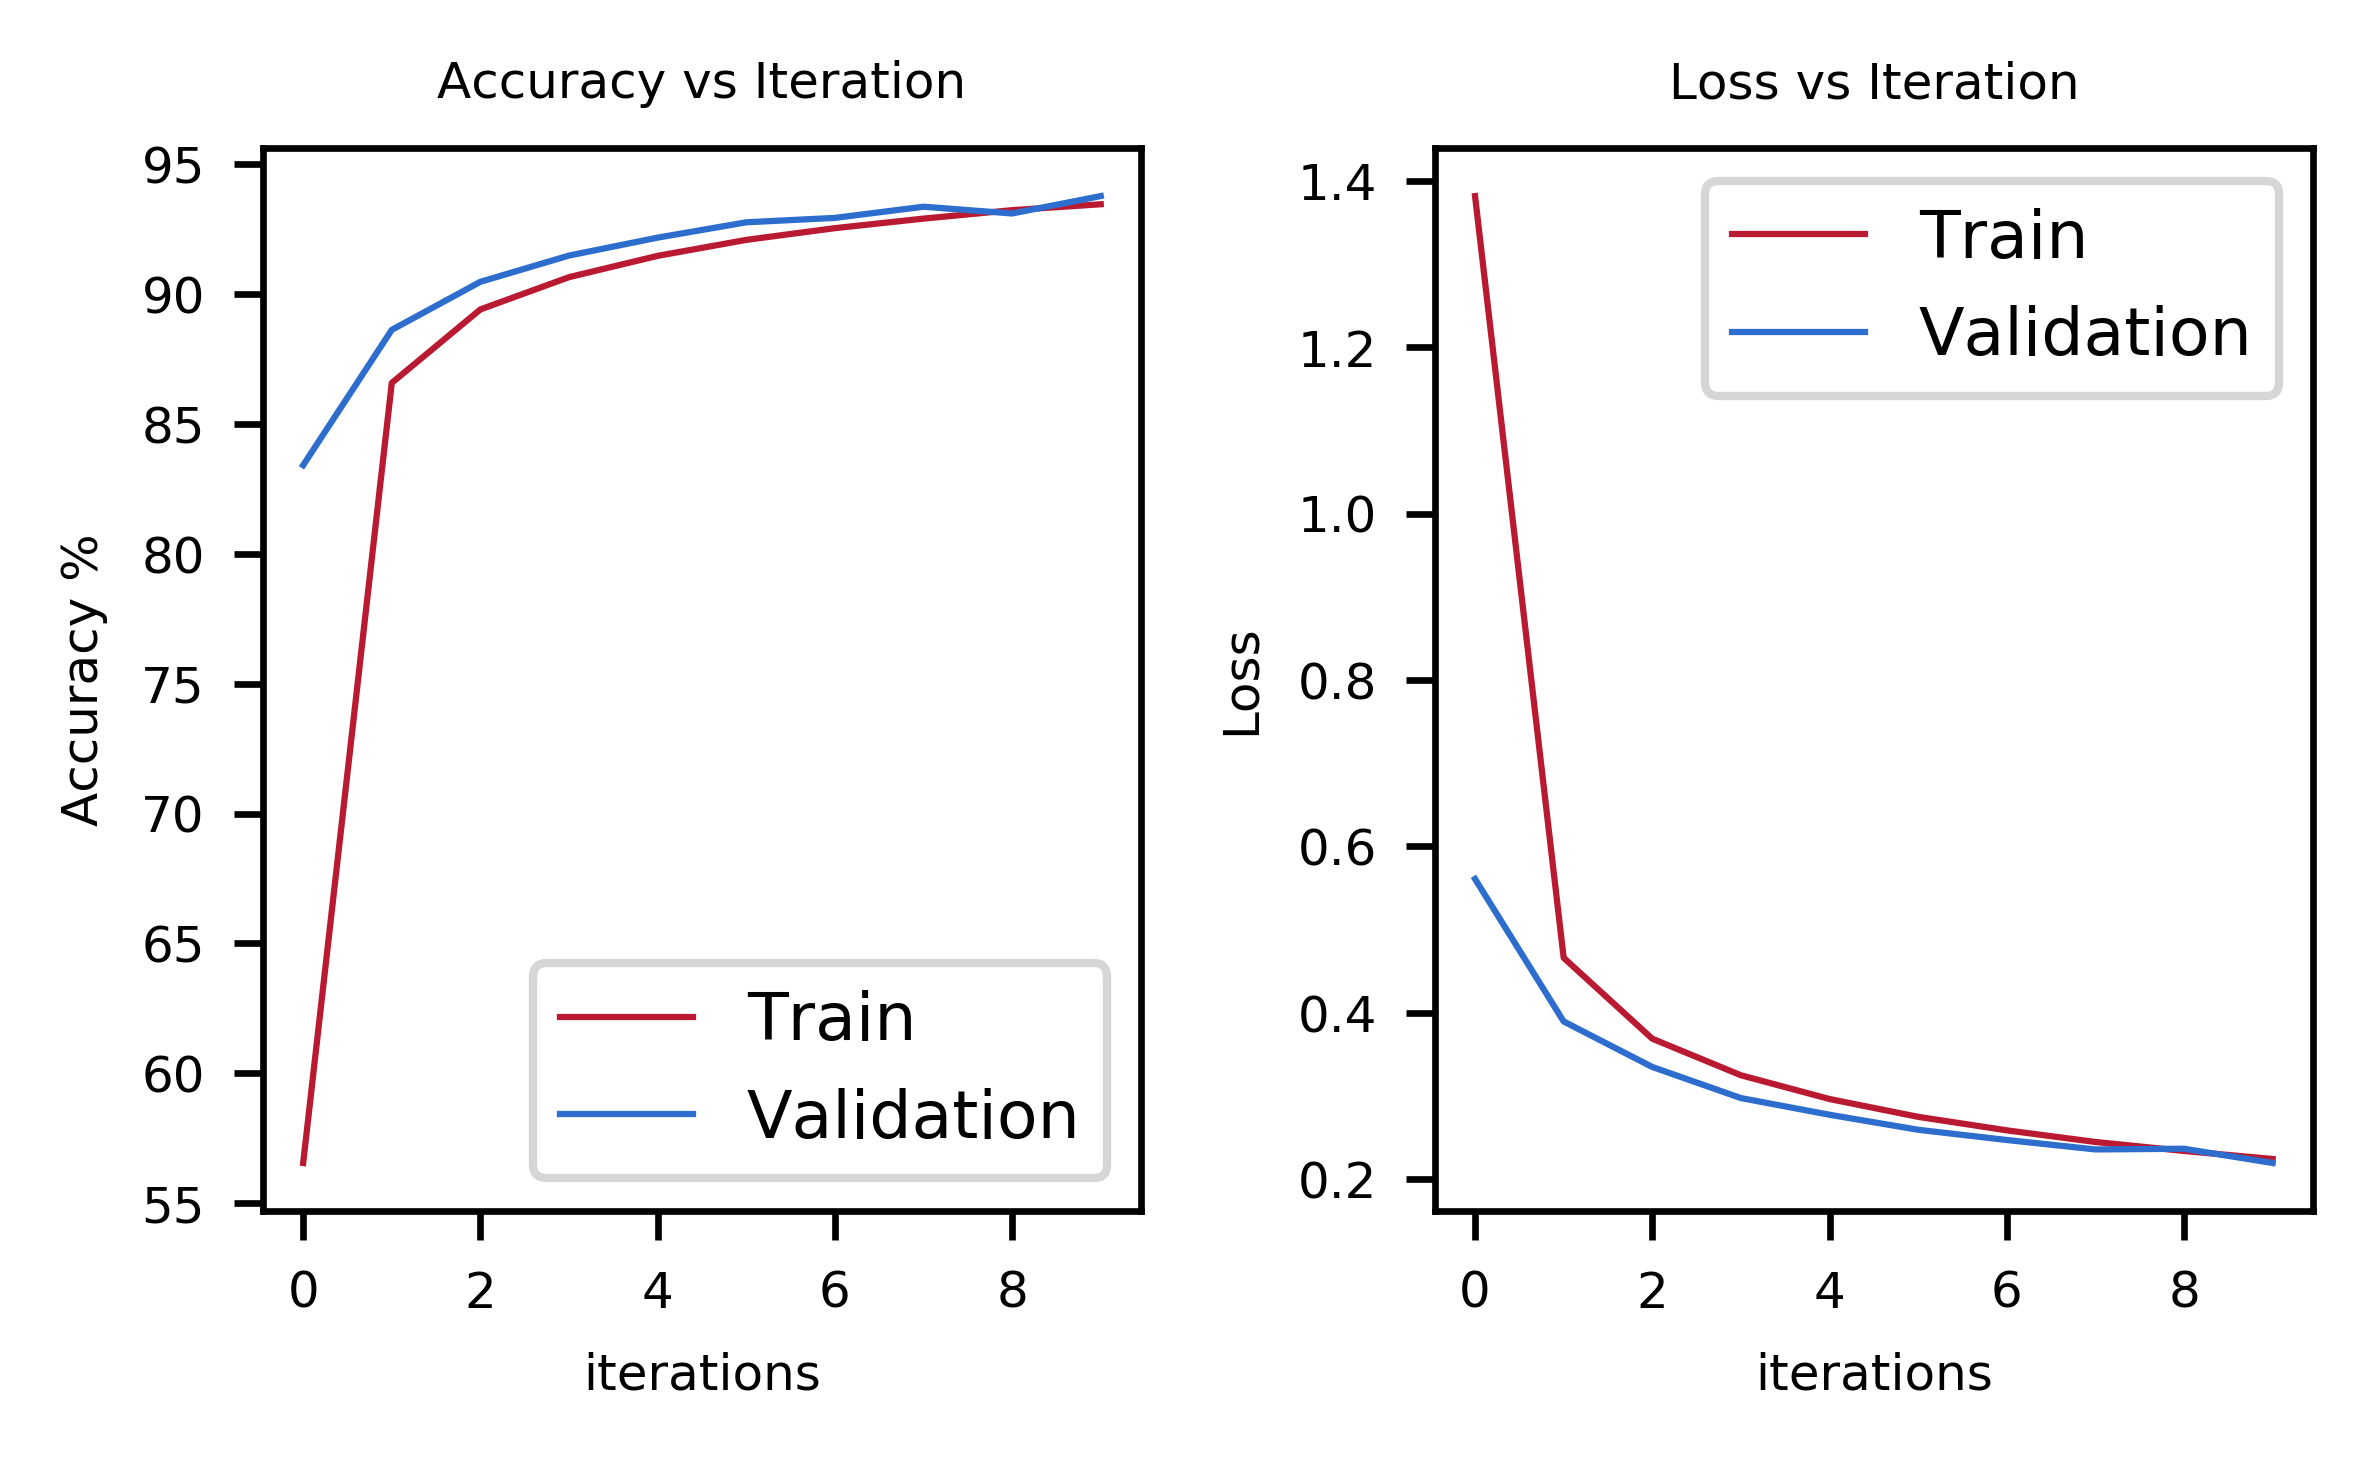

In [55]:
fit_model(model_early_stopping , optimizer, 10)

** Questions**
1. From the above figure does the model overfit or underfit?
2. If you were to stop training once the validation accuracy start to decrease, at what epoch (iteration) would you stop?
3. Implement the basic early stopping approche by modifying the above code.
4. Compare your results with the previous default model.

### Early stopping after T epoch, model saving  and model checkpoint
For this lab, we will implement **Early stopping after T epoch**: training for T epochs, and simply selecting the best model based on validation score over the entire T epochs by following the following steps by modifying the previous train function and call valadation(test) function after each epoch. To achieve this we will follow the follwing steps:

1. Redifine a train function and we will call it fit function.
2. Define a validation function
3. Define a model checkpoint and saving function
4. Define and call model train function

### 3.1.1 Define fit function

In [61]:
def fit(model, optimizer, criterion, train_loader):
    
    running_loss = 0
    correct  = 0
    model.train()
    
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs.data, 1)
            
            
        running_loss += loss.data[0] * images.size(0)
        
        #find accuracy
        correct += torch.sum(preds == labels.data)
        
        
        loss.backward()
        optimizer.step()
        
    tra_loss=running_loss/len(train_loader.dataset)
    tra_cc=100. * correct / len(train_loader.dataset)
    
    return tra_loss, tra_cc

### 3.1.2 Define validate function.

In [62]:
def validate(model, optimizer, criterion, test_loader):
    
    model.eval()
    running_loss = 0
    correct  = 0
    
    for i, (images, labels) in enumerate(test_loader):
        
        images = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        outputs = model(images)
            
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs.data, 1)
            
        # statistics
        running_loss += loss.data[0] * images.size(0)
        correct += torch.sum(preds == labels.data)
            
    val_loss=running_loss/len(test_loader.dataset)
    val_acc=100. * correct / len(test_loader.dataset) 
        
    return val_loss, val_acc
    

### 3.1.3 Define model save checkpoint function

This function will be used to save the best model. Pytorch offer `torch.save()` and `torch.load()` for saving and loading saved models respectively.We will use [shutill](https://docs.python.org/3/library/shutil.html) python library  to save the best model with its associated parameters. Shutill offers a number of high-level operations on files and collections of files.

In [63]:
import shutil

def save_checkpoint(state, is_best, model_path):
    
    torch.save(state, model_path)
    
    if is_best:
        print("Saving best model")
        shutil.copyfile(model_path, 'model_best.pth.tar')



Finaly we defin a model train function

In [64]:
def train_model(model, optimizer, criterion, train_loader, test_loader, num_epochs, save_path):
    
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    
    best_score = 0
    
    print("Start training")
    for epoch in range(num_epochs):
        
        #fit model
        loss_tra, acc_tra = fit(model, optimizer, criterion, train_loader)
        train_loss.append(loss_tra)
        train_acc.append(train_acc)
        
        #validate model
        loss_val, acc_val = validate(model, optimizer, criterion, test_loader)
        val_loss.append(loss_val)
        val_loss.append(acc_val)
        
        is_best = acc_val >  best_score
        best_score = max(acc_val, best_score)
        
        save_checkpoint(state={
            'epoch': epoch + 1,
            'arch': "MLP",
            'state_dict': model.state_dict(),
            'best_score': best_score,
            'optimizer' : optimizer.state_dict(),
        }, is_best=is_best,model_path=save_path)
        
        print("Best score is: {:.3f}, current score is: {:.3f}".format(best_score, acc_val))
        
        
        print("Epoch: {}, Train loss: {:.4f} , Valid loss: {:.4f},Train accuracy: {:.2f}, Valid Accuracy: {:.2f}".format(epoch, loss_tra, 
                                                                 loss_val, acc_tra, acc_val))
        print('----------------------------------------------------------------------------------------------------')
    Loss = {"train": train_loss, "val":val_loss}  
    Accuracy =  {"train": train_acc, "val":val_acc}
    
    return Loss, Accuracy   

We can run our model by calling the train_model function

In [65]:
save_path = '../tmp/MLP_checkpoint.pth.tar'
model_early_stopping =  MLP(input_dim, hidden_dim, output_dim)
optimizer =  torch.optim.SGD(model_early_stopping .parameters(), lr=learning_rate, momentum=0.9)
loss, acc = train_model(model_early_stopping, optimizer, criterion, train_loader, test_loader, 10, save_path)

Start training
Saving best model
Best score is: 82.000, current score is: 82.000
Epoch: 0, Train loss: 1.5560 , Valid loss: 0.6195,Train accuracy: 48.08, Valid Accuracy: 82.00
----------------------------------------------------------------------------------------------------
Saving best model
Best score is: 88.820, current score is: 88.820
Epoch: 1, Train loss: 0.4682 , Valid loss: 0.3776,Train accuracy: 86.51, Valid Accuracy: 88.82
----------------------------------------------------------------------------------------------------
Saving best model
Best score is: 90.040, current score is: 90.040
Epoch: 2, Train loss: 0.3597 , Valid loss: 0.3410,Train accuracy: 89.61, Valid Accuracy: 90.04
----------------------------------------------------------------------------------------------------
Saving best model
Best score is: 90.970, current score is: 90.970
Epoch: 3, Train loss: 0.3192 , Valid loss: 0.3028,Train accuracy: 90.78, Valid Accuracy: 90.97
--------------------------------------

### Load Saved mode

To load pytorch saved modals use `torch.load`.

In [66]:
def load_saved_modal(saved_model_path, modal, optimizer):
    if os.path.isfile(saved_model_path):
        print("=> loading checkpoint '{}'".format(saved_model_path))
        checkpoint = torch.load(saved_model_path)
        start_epoch = checkpoint['epoch']
        best_score = checkpoint['best_score']
        modal.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {})".format(saved_model_path, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(saved_model_path))
        best_score = 0
        start_epoch =0    


In [68]:
import os
load_saved_modal(save_path, model_early_stopping, optimizer)

=> loading checkpoint '../tmp/MLP_checkpoint.pth.tar'
=> loaded checkpoint '../tmp/MLP_checkpoint.pth.tar' (epoch 10)


## 3.4 Dropout 

Dropout[1] is a technique for regularizing neural networks by randomly setting some features to zero during the forward pass. 

[1] Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012

In [69]:
def MLP_dropout(input_dim, hidden_dim, output_dim, drop_prob):
    
    model = nn.Sequential(
    nn.Linear(input_dim,hidden_dim), nn.ReLU(), nn.Dropout(p=drop_prob),
    nn.Linear(hidden_dim,hidden_dim),nn.ReLU(), nn.Dropout(p=drop_prob),
    nn.Linear(hidden_dim,output_dim)
    )
    
    return model

In [70]:
drop_prob = 0.25
input_dim = 784 #28X28
hidden_dim = 16
output_dim = 10
model_drop = MLP_dropout(input_dim, hidden_dim, output_dim, drop_prob)
print(model_drop)

Sequential(
  (0): Linear(in_features=784, out_features=16, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.25)
  (3): Linear(in_features=16, out_features=16, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.25)
  (6): Linear(in_features=16, out_features=10, bias=True)
)


In [ ]:
optimizer =  torch.optim.SGD(model_drop.parameters(), lr=learning_rate, momentum=0.9)
total_loss_drop = train(model_drop , optimizer, 5)

## Task:
1. Run an experiment for different dropout probability $p=0, 0.25, 0.5, 0.75$. 
2. Compare the total loss for each dropout probability.
3. Comments on your results